In [4]:
import pandas as pd
import numpy as np
td = pd.read_csv('titanic-data.csv')
td.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 问题：船上乘客的生还率和哪些因素密切相关？

### 先看看生还率和性别之间的关系

从下面的数据可以看出男性幸存者的比例明显偏小
男性人数占到了所有乘客的64.8%，但在幸存者中男性只占比31.9%

In [8]:
def check_diff(df, filter, col_name, kv):
    df2 = df
    if filter is not None:
        df2 = df[filter]
    one_col = df2[col_name]
    total_count = one_col.size
    msgs = []
    for key in kv:
        percent = 1.0*one_col[one_col==key].size / total_count
        msgs.append('%s: %f'%(kv[key], percent))
    print " ; ".join(msgs)

check_diff(td, None, 'Sex', {'male':'男性占比', 'female':'女性占比'})
check_diff(td, None, 'Survived', {0:'不在', 1:'幸存'})
check_diff(td, td.Survived==1, 'Sex', {'male':'幸存者中男性占比', 'female':'幸存者中女性占比'})



男性占比: 0.647587 ; 女性占比: 0.352413
不在: 0.616162 ; 幸存: 0.383838
幸存者中男性占比: 0.318713 ; 幸存者中女性占比: 0.681287


### 看一下生还率和年龄之间的关系

蓝色的是全体乘客的年龄分布直方图，橙色的是生还乘客的年龄分布直方图，两者总体分布相近，所以推测年龄和是否生还没有直接联系。

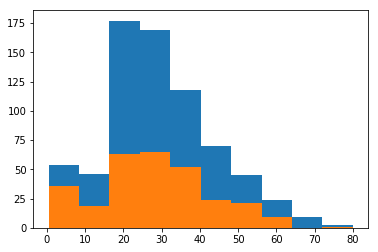

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def check_hist(df, filter, col_name):
    df2 = df
    if filter is not None:
        df2 = df[filter]
    plt.hist(df2[col_name].dropna())

check_hist(td, None, "Age")
check_hist(td, td.Survived==1, "Age")


### 看一下生还率和SibSp（同船兄弟姐妹或配偶个数）之间的关系

（这里使用了上面的函数check_hist）

全体乘客和生还乘客的SibSp个数分布趋势相近，因此推测SibSp和是否生还关系不大

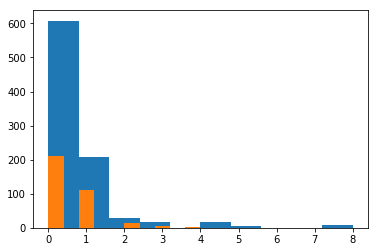

In [8]:
check_hist(td, None, "SibSp")
check_hist(td, td.Survived==1, "SibSp")

### 看一下生还率和parch（同船父母或子女个数）之间的关系

全体乘客和生还乘客的Parch个数分布趋势相近，因此推测Parch和是否生还关系不大

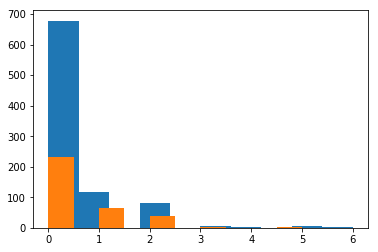

In [10]:
check_hist(td, None, "Parch")
check_hist(td, td.Survived==1, "Parch")

看一下生还率和Parch与SibSp综合起来是否相关
全体乘客和生还乘客的分布依然相近，所以Parch和SibSp综合起来看也和是否生还关系不大

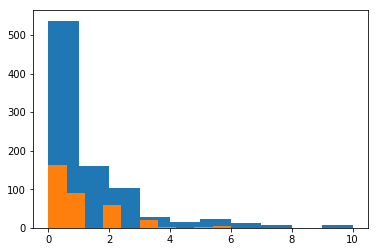

In [13]:
td['ParchPlusSibSp'] = td['Parch']+td['SibSp']
check_hist(td, None, "ParchPlusSibSp")
check_hist(td, td.Survived==1, "ParchPlusSibSp")

－－－－－－－－－－－－－－－below are temp

In [43]:
df2 = pd.DataFrame({ 'A' : 1.,
    'B' : pd.Timestamp('20130102'),
    'C' : pd.Series(1,index=list(range(4)),dtype='float32'),
    'D' : np.array([3] * 4,dtype='int32'),
    'E' : pd.Categorical(["test","train","test","train"]),
    'F' : 'foo' })
df2[True]

KeyError: True